In [1]:
import numpy as np
import time
from geoarray import GeoArray
import scipy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [31]:
data = GeoArray('/Users/varunpatro/Desktop/ang20160126t055327_rfl_v2m2/ang20160126t055327_corr_v2m2_img')
print(data.shape)
print(type(data))

(5618, 704, 425)
<class 'geoarray.baseclasses.GeoArray'>


In [6]:
def remove_bad_bands(spectra: np.array):
    bands = list(range(1,426))
    bands = np.array(bands)
    deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 215), np.logical_and(bands > 275, bands < 325))
    bad_cal = bands > 418
    bad = np.logical_or(deeph2o, bad_cal)
    spectra[bad] = np.nan

# SavGol smoothening function

def savgol_smoothening(spectra_list:list):
    for spectra in spectra_list:
        noise_peak_1 = spectra[105:120].copy()
        noise_peak_2 = spectra[140:165].copy()
        spectra[105:120] = savgol_filter(noise_peak_1, 11,1)
        spectra[140:165] = savgol_filter(noise_peak_2, 21, 1)
        
                       

In [32]:
# is taking about 2 minutes to chop
start_time = time.time()
data = data[50:5501, 150:601, :] # removing peripheral pushbroom effects
print("--- %s seconds ---" % (time.time() - start_time))

--- 74.34982705116272 seconds ---


In [33]:
svgy_p1 = data[:,:,105:120].copy()
print('shape: ', svgy_p1.shape)
svgy_p1 = svgy_p1.reshape((svgy_p1.shape[0]*svgy_p1.shape[1], svgy_p1.shape[2]))
print('reshapen: ', svgy_p1.shape)
svgy_p2 = data[:,:,140:165].copy()
print('shape: ', svgy_p2.shape)
svgy_p2 = svgy_p2.reshape((svgy_p2.shape[0]*svgy_p2.shape[1], svgy_p2.shape[2]))
print('reshapen: ', svgy_p2.shape)

shape:  (5451, 451, 15)
reshapen:  (2458401, 15)
shape:  (5451, 451, 25)
reshapen:  (2458401, 25)


Unaltered 1: (2458401, 15)
Post SavGol 1: (2458401, 15)


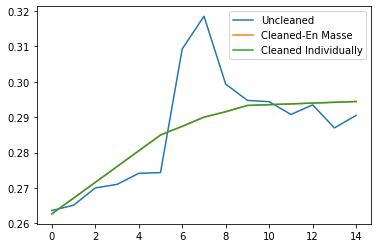

In [34]:
copy_1 = svgy_p1.copy() # duplicate of svgy1
test = svgy_p1[10].copy()
test = savgol_filter(test, 11, 1)
clean_1 = savgol_filter(svgy_p1, 11, 1, axis = 1)
print('Unaltered 1:', copy_1.shape)
print('Post SavGol 1:', svgy_p1.shape)



plt.plot(copy_1[10], label = 'Uncleaned')
plt.plot(clean_1[10], label = 'Cleaned-En Masse')
plt.plot(test, label = 'Cleaned Individually')
plt.legend()




Unaltered 2:  (2458401, 25)
Post SavGol 2:  (2458401, 25)


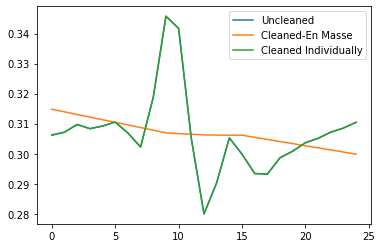

In [35]:
copy_2 = svgy_p2.copy()
test = svgy_p2[30].copy()
clean_2 = savgol_filter(svgy_p2, 19, 1, axis = 1)
print('Unaltered 2: ', copy_2.shape)
print('Post SavGol 2: ', svgy_p2.shape)

plt.plot(copy_2[30], label = 'Uncleaned')
plt.plot(clean_2[30], label = 'Cleaned-En Masse')
plt.plot(test, label = 'Cleaned Individually')
plt.legend()

In [36]:
start_time = time.time()
copy_1 = svgy_p1.copy() # duplicate of svgy1
svgy_p1 = savgol_filter(svgy_p1, 11, 1, axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p1.shape)
start_time = time.time()
copy_2 = svgy_p2.copy()
svgy_p2 = savgol_filter(svgy_p2, 19, 1, axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p2.shape)

--- 3.3688547611236572 seconds ---
(2458401, 15)
--- 5.446845054626465 seconds ---
(2458401, 25)


In [37]:
svgy1_bands = 15
svgy2_bands = 25

In [38]:
start_time = time.time()
svgy_p1 = svgy_p1.reshape(data.shape[0], data.shape[1], svgy1_bands)
data[:,:,105:120] = svgy_p1.copy()
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p1.shape)
start_time = time.time()
svgy_p2 = svgy_p2.reshape(data.shape[0], data.shape[1], svgy2_bands)
data[:,:,140:165] = svgy_p2.copy()
print("--- %s seconds ---" % (time.time() - start_time))
print(svgy_p2.shape)

--- 0.3936581611633301 seconds ---
(5451, 451, 15)
--- 0.7375428676605225 seconds ---
(5451, 451, 25)


In [39]:
data.shape

(5451, 451, 425)

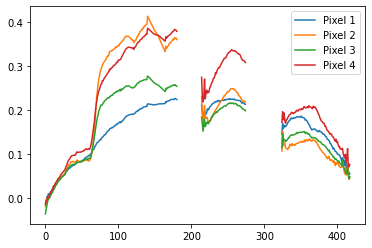

In [40]:
# checking to see if the cleaning worked
for i in range(4):
    spectra = data[np.random.randint(1,5000),np.random.randint(1,400),:].copy()
    remove_bad_bands(spectra)
    plt.plot(spectra, label = 'Pixel ' + str(i+1))
plt.legend()
    
    

In [41]:
# takes no time at all
start_time = time.time()
spectra_list = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005257129669189453 seconds ---


In [42]:
# clustering takes a little over 3 min
start_time = time.time()
seed = 8
kmeans = KMeans(init='k-means++', n_clusters = 4, n_init=10, random_state=seed).fit(spectra_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 752.4339530467987 seconds ---


In [43]:
print(type(kmeans.cluster_centers_))
print(type(kmeans.cluster_centers_[0]))
print(kmeans.cluster_centers_[0].shape)
means = kmeans.cluster_centers_
print(means.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(425,)
(4, 425)


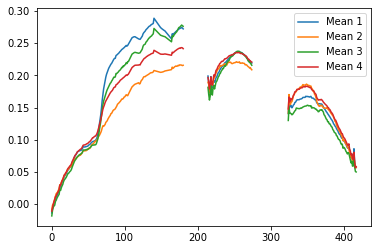

In [44]:
for i in range(means.shape[0]):
    remove_bad_bands(means[i])
    plt.plot(means[i], label = 'Mean ' + str(i+1))
plt.legend()